# Process LevSeq

Here we want to join the LevSeq output data with the function data from the LCMS.


NEED TO CHECK THIS FILE! 20240404-JR-SSM-NOPiv-E1-E2_20240403-JR barcodes for -E2 seem wrong?

In [15]:
import pandas as pd
# get all the sequnence function files and see what those specific mutations did
# Also did any of the other mutations appear in the H2NOH files
import os
from copy import deepcopy
# Get them w.r.t to a mutation
from scipy.stats import mannwhitneyu
# get all the sequnence function files and see what those specific mutations did
# Also did any of the other mutations appear in the H2NOH files
import os
import numpy as np
from tqdm import tqdm
from sciutil import SciUtil

output_dir = 'output/'

lineage_df = pd.read_csv('lineage_summary.tsv', sep='\t')
lineage_df['name'] = [f'{l}_{n}' for l, n in lineage_df[['linage', 'name']].values]
# Keep track of the parents for the LevSeq data
lineage_df['AA'] = [d.replace('*', '') for d in lineage_df['AA'].values]
parent_to_name = dict(zip(lineage_df.AA, lineage_df.name))
parents = list(set(lineage_df.AA.values))

In [17]:


# Amino acid code conversion
AA_DICT = {
    "Ala": "A",
    "Cys": "C",
    "Asp": "D",
    "Glu": "E",
    "Phe": "F",
    "Gly": "G",
    "His": "H",
    "Ile": "I",
    "Lys": "K",
    "Leu": "L",
    "Met": "M",
    "Asn": "N",
    "Pro": "P",
    "Gln": "Q",
    "Arg": "R",
    "Ser": "S",
    "Thr": "T",
    "Val": "V",
    "Trp": "W",
    "Tyr": "Y",
    "Ter": "*",
}


def normalise_calculate_stats(processed_plate_df, value_column, normalise="standard", stats_method="mannwhitneyu", parent_label="#PARENT#", normalise_method="median", parent_to_name = None):
    # if nomrliase normalize with standard normalisation
    normalised_df = pd.DataFrame()
    all_stats_df = pd.DataFrame()
    processed_plate_df[value_column] = pd.to_numeric(processed_plate_df[value_column], errors='coerce')

    for plate in set(processed_plate_df["barcode_plate"].values):
        # Normalize for each value
        plate_parent = None
        plate_campaign = None
        sub_df = processed_plate_df[processed_plate_df["barcode_plate"] == plate].copy()
        parent_values = sub_df[sub_df["amino_acid_substitutions"] == parent_label][value_column].values
        if len(parent_values) == 0:
            u.err_p(['No parent!!! skipping... '])
            print(plate)
            print(sub_df.head())
            parent_values = sub_df[value_column].values
            continue
        else:
            # By default use the median
            if normalise_method == "median":
                parent_mean = np.nanmedian(parent_values)
            else:
                parent_mean = np.nanmean(parent_values)
            parent_sd = np.nanstd(parent_values)
    
            # For each plate we normalise to the parent of that plate
            sub_df[f"{value_column} plate standard norm"] = (sub_df[value_column].values - parent_mean) / parent_sd
            sub_df[f"{value_column} fold change"] = sub_df[value_column].values/ parent_mean

            norm_value_column = f"{value_column} plate standard norm"    
            sd_cutoff = 1.5  # The number of standard deviations we want above the parent values
            # Now for all the other mutations we want to look if they are significant, first we'll look at combinations and then individually
            grouped_by_mutations = sub_df.groupby("amino_acid_substitutions")
        
            rows = []
            for mutation, grp in grouped_by_mutations:
                # Get the values and then do a ranksum test
                if mutation != parent_label:
                    vals = list(grp[norm_value_column].values)
                    U1, p = None, None
                    # Now check if there are 3 otherwise we just do > X S.D over - won't be sig anyway.
                    if len(grp) > 2:
                        # Do stats
                        U1, p = mannwhitneyu(parent_values, vals, method="exact")
                    if normalise_method == "median":
                        mean_vals = np.nanmedian(vals)
                    else:
                        mean_vals = np.nanmean(vals)
                    std_vals = np.nanstd(vals)
                    median_vals = np.nanmedian(vals)
                    sig = mean_vals > ((sd_cutoff * parent_sd) + parent_mean)
                    rows.append([value_column, mutation, len(grp), mean_vals, std_vals, median_vals, mean_vals, sig, U1, p, plate_campaign, plate_parent, plate])
            stats_df = pd.DataFrame(rows, columns=["value_column",  "amino_acid_substitutions", "number of wells with amino_acid substitutions", "mean",
                    "std", "median", "amount greater than parent mean", f"greater than > {sd_cutoff} parent", "man whitney U stat",
                    "p-value", 'campaign',  'parent', 'plate'],
                )
            all_stats_df = pd.concat([all_stats_df, stats_df])
            normalised_df = pd.concat([normalised_df, sub_df])

    return all_stats_df, normalised_df


def get_dist(seq1, seq2):
    seq1 = list(seq1)
    seq2 = list(seq2)
    dist = 0
    if len(seq1) != len(seq2):
        print(len(seq1), len(seq2), 'YIKES')
    for i in range(0, len(seq1)):
        if seq1[i] != seq2[i]:
            dist += 1
    #print(dist/len(seq1))
    return dist/len(seq1)



In [18]:

u = SciUtil()

all_dfs = {}
all_stats_dfs = pd.DataFrame()
all_df = pd.DataFrame()

for base_dir in ['LCMS/NOPiv-linage_Done', 'LCMS/H2NOH-linage_Done',]:
    files = [f for f in os.listdir(base_dir) if '.csv' in f]
    for f in files:
        # Get all the sequence function files.
        run_name = f.replace('.csv', '')
        if os.path.exists(os.path.join(base_dir, run_name)):
            function_files = os.listdir(os.path.join(base_dir, run_name))
            
            all_function_df = pd.DataFrame()
            for function_file in function_files:
                try:
                    # Barcode
                    barcode = function_file.split('.csv')[0].split('_')[-1]
                    function_df = pd.read_csv(f'{base_dir}/{run_name}/{function_file}', header=1)
                    # Now we want to line up the barcode with the file and then join on the wells
                    function_df['function_well'] = [x.split('-')[-1] if isinstance(x, str) else None for x in function_df['Sample Vial Number'].values]
                    function_df['function_barcode_plate'] = barcode
                    u.dp([f, set(function_df['Compound Name'].values)])
                    function_df = function_df[function_df['Compound Name'].isin(['Pdt', 'pdt'])]
                    function_df['Area'] = pd.to_numeric(function_df['Area'], errors='coerce')

                    function_df['barcode_well'] = [f'{p}_{w}' for w, p in function_df[['function_well', 'function_barcode_plate']].values]
                    function_df['filename'] = function_file
                    all_function_df = pd.concat([all_function_df, function_df])
                except:
                    print('fuction file', function_file)
            df = pd.read_csv(f'{base_dir}/{f}')
            
            df.columns = [c.lower() for c in df.columns]
            if 'barcode_plate' not in df.columns:
                df = df.rename(columns={'protein sequence': 'aa_sequence'})
                df['barcode_plate'] = df['plate'].values

            df['barcode_well'] = [f'{p}_{w}' for w, p in df[['well', 'barcode_plate']].values]
            # Join the two
            df.set_index('barcode_well', inplace=True)
            all_function_df.set_index('barcode_well', inplace=True)
            df = df.join(all_function_df, how='left')
            df.reset_index(inplace=True, drop=True)
            df['levSeq_filename'] = run_name
            df.columns = [c.replace(' ', '_') for c in df.columns]
            df = df[['barcode_plate',
                     'plate',
                     'nucleotide_mutation',
                     'amino_acid_substitutions',
                     'well', 
                     'average_mutation_frequency', 
                     'alignment_count',
                     'aa_sequence',
                   'Sample_Acq_Order_No', 'Sample_Vial_Number', 'Sample_Name',
                   'Compound_Name', 'RT_[min]', 'Area', 'function_well',
                   'function_barcode_plate', 'filename', 'levSeq_filename']]
            df = df.loc[:,~df.columns.duplicated()].copy()
            # Need to add in the fitness and the fitness_value	smiles_string
            df['fitness_value'] = df['Area'].values
            if base_dir == 'LCMS/NOPiv-linage_Done':
                df['smiles_string'] = 'O=C(OC)C[C@H](N)C1=CC=CC=C1'
            else:
                df['smiles_string'] = 'O=C(OC)C[C@H](N)C1=CC=CC=C1'
            # Get which parent it is
            min_dist = 1000
            generation_name = None
            aa = df[df['amino_acid_substitutions'] == '#PARENT#']['aa_sequence'].values[0].replace('*', '')
            aa = aa.replace('*', '')
            for p in parents:
                parent_dist = get_dist(p, aa)
                if parent_dist < min_dist:
                    min_dist = parent_dist
                    generation_name = parent_to_name.get(p)
            #print(generation_name)
            df['campaign_name'] = generation_name
            all_dfs[run_name] = df

            df = df.drop_duplicates(subset=['barcode_plate', 'well'])
            df = df.fillna(0)
            df.to_csv(f'{output_dir}/seqfunc/{generation_name}_{f}')
            stats_df, df = normalise_calculate_stats(df, 'Area',
                            normalise="standard",
                            stats_method="mannwhitneyu",
                            parent_label="#PARENT#",
                            normalise_method="mean",
                            parent_to_name = parent_to_name)
            stats_df['levSeq_filename'] = run_name
            all_df = pd.concat([all_df, df])
            all_stats_dfs =  pd.concat([all_stats_dfs, stats_df])
            all_df = pd.concat([all_df, df])
            u.warn_p(['Success!', run_name, generation_name, 'Distance between parent and generation:', min_dist, 
                     
                     '\n # non zero fitness: ', len(df[df['fitness_value'] != 0]), '\n Size of dataset: ', len(df), 
                                                    '\n # unique sustitutions: ', len(set(df['amino_acid_substitutions'].values))])
            # Also print the number of non-zero fitness values

all_df

--------------------------------------------------------------------------------
                       20241115-JR-SSM-NOPiv.csv	{'Pdt'}	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       20241115-JR-SSM-NOPiv.csv	{'Pdt'}	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       20241115-JR-SSM-NOPiv.csv	{'Pdt'}	                       
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                       20241115-JR-SSM-NOPiv.csv	{'Pdt'}	                       
--------------------------------------------------------------------------------
----------------------------

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/694227509.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_function_df = pd.concat([all_function_df, function_df])
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/694227509.py:81: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/750155235.py:54: RuntimeWarning: invalid value encountered in divide
  sub_df[f"{value_column} plate standard norm"] = (sub_df[valu

--------------------------------------------------------------------------------
Success!	20240416-JR-SSM-NOPiv	NOPiv_G7-1	Distance between parent and generation:	0.0049261083743842365	
 # non zero fitness: 	558	
 Size of dataset: 	576	
 # unique sustitutions: 	109	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                      20240726-JR-epPCR-NOPiv.csv	{'Pdt'}	                      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                      20240726-JR-epPCR-NOPiv.csv	{'Pdt'}	                      
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                      20240726-JR-epPCR-NOPiv.csv	{'Pdt'}	                      
----

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/750155235.py:54: RuntimeWarning: invalid value encountered in divide
  sub_df[f"{value_column} plate standard norm"] = (sub_df[value_column].values - parent_mean) / parent_sd
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/750155235.py:55: RuntimeWarning: invalid value encountered in divide
  sub_df[f"{value_column} fold change"] = sub_df[value_column].values/ parent_mean
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/750155235.py:75: RuntimeWarning: Mean of empty slice
  mean_vals = np.nanmean(vals)
/Users/arianemora/miniconda3/envs/levseq/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/750155235.py:77: RuntimeWarning: All-NaN slice encountered
  median_vals = np.nanmedian(vals)
/var/folders/s

--------------------------------------------------------------------------------
Success!	20240504-JR-StEP-H2NOH	H2NOH_G2	Distance between parent and generation:	0.0	
 # non zero fitness: 	543	
 Size of dataset: 	672	
 # unique sustitutions: 	167	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                        20250319_SSM-H2NOH.csv	{'Pdt'}	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                        20250319_SSM-H2NOH.csv	{'Pdt'}	                         
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                        20250319_SSM-H2NOH.csv	{'Pdt'}	                         
-----------------------

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/750155235.py:54: RuntimeWarning: divide by zero encountered in divide
  sub_df[f"{value_column} plate standard norm"] = (sub_df[value_column].values - parent_mean) / parent_sd
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/750155235.py:54: RuntimeWarning: invalid value encountered in divide
  sub_df[f"{value_column} plate standard norm"] = (sub_df[value_column].values - parent_mean) / parent_sd
/Users/arianemora/miniconda3/envs/levseq/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/arianemora/miniconda3/envs/levseq/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1899: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_86746/750155235.py:54:

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,Area,function_well,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change
0,1,G12-2-M86C-W62X,0,#N.A.#,A1,0.000000,0.0,#N.A.#,2.0,D4F-A1,...,0.0000,A1,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,0.0000,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-1.259898,0.000000
1,1,G12-2-M86C-W62X,A256T_T257G_G258T,#PARENT#,A2,0.916667,24.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,3.0,D4F-A2,...,521668.1625,A2,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,521668.1625,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,0.968485,1.768701
2,1,G12-2-M86C-W62X,T184G_G185A_A256T_T257G_G258T,W62E,A3,0.653333,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,4.0,D4F-A3,...,431005.6363,A3,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,431005.6363,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,0.581206,1.461312
3,1,G12-2-M86C-W62X,T184A_G185A_G186T_A256T_T257G_G258T,W62N,A4,0.977778,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,5.0,D4F-A4,...,130218.5864,A4,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,130218.5864,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.703650,0.441502
4,1,G12-2-M86C-W62X,T184A_G186T_A256T_T257G_G258T,#LOW#,A5,0.920000,5.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,0.0,0,...,0.0000,0,0,0,20241115-JR-SSM-NOPiv,0.0000,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-1.259898,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,40,ep-P8,T193C_T420A_T553A,S65P_W185R,H8,0.928205,65.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,93,D6B-H8,...,77850.9941,H8,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,77850.9941,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-7.047915,0.177677
764,40,ep-P8,#PARENT#,#PARENT#,H9,0.000000,283.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,94,D6B-H9,...,407279.0180,H9,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,407279.0180,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-0.604060,0.929521
765,40,ep-P8,A29T,D10V,H10,0.937173,191.0,MTPSDIPGYVYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,95,D6B-H10,...,208648.1904,H10,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,208648.1904,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-4.489425,0.476192
766,40,ep-P8,T78G_T204C_A317C_T408A_T470A_C600DEL,LEN,H11,0.914993,249.0,#DEL#,96,D6B-H11,...,0.0000,H11,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,0.0000,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-8.570738,0.000000


# Make some summaries about the dataset

First check what campaigns are represented.

In [21]:
# Remove any with no fitness data
all_df = all_df[~all_df['Area'].isna()]

# Remove non-0 fitnesses
all_df = all_df[all_df['fitness_value'] > 0.0]

all_df['campaign_name'].value_counts()

campaign_name
NOPiv_G7-1     2410
H2NOH_G5       2084
H2NOH_G2       1588
H2NOH_G6-2      888
H2NOH_G6        866
NOPiv_G13-2     758
H2NOH_G4        750
H2NOH_G3        704
NOPiv_G7-2      554
NOPiv_G9-2      468
NOPiv_G10-2     206
Name: count, dtype: int64

In [22]:
# Next remove any values that we're not sure about i.e. low or NA in the sequenceing

nn_df = all_df[all_df['amino_acid_substitutions'] != '#N.A.#']
nn_df = nn_df[nn_df['amino_acid_substitutions'] != '#LOW#']
nn_df = nn_df[nn_df['amino_acid_substitutions'] != 'LEN']
nn_df = nn_df[nn_df['amino_acid_substitutions'] != '#PARENT#']

nn_df['amino_acid_substitutions'].value_counts()

amino_acid_substitutions
I149L                         120
L56V                           74
F73V                           52
L56K                           50
I146V                          46
                             ... 
N75D_V89I_W93L_V127D_A134V      2
P138Q_I149L                     2
V89I_W93L_A134G_I149L           2
V38I_A59M_A91P_A134V_I149L      2
D10V                            2
Name: count, Length: 1106, dtype: int64

In [23]:
len(all_df)

11276

In [32]:
nn_df = nn_df.drop_duplicates(subset=['nucleotide_mutation', 'fitness_value'])
nn_df

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,function_well,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,# substitutions
2,1,G12-2-M86C-W62X,T184G_G185A_A256T_T257G_G258T,W62E,A3,0.653333,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,4.0,D4F-A3,...,A3,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,431005.6363,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,0.581206,1.461312,1
3,1,G12-2-M86C-W62X,T184A_G185A_G186T_A256T_T257G_G258T,W62N,A4,0.977778,15.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,5.0,D4F-A4,...,A4,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,130218.5864,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.703650,0.441502,1
8,1,G12-2-M86C-W62X,T184G_G185T_G186T_A256T_T257G_G258T,W62V,A9,0.904255,47.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,7.0,D4F-A9,...,A9,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,91746.0809,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.867991,0.311062,1
9,1,G12-2-M86C-W62X,T184A_G186T_A256T_T257G_G258T,W62S,A10,0.964103,39.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,8.0,D4F-A10,...,A10,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,100422.7253,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.830927,0.340480,1
10,1,G12-2-M86C-W62X,T184G_G185T_A256T_T257G_G258T,W62V,A11,0.937931,29.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEEDIMYLKKAAD...,9.0,D4F-A11,...,A11,1,JR-20241115-M86C_W62X_1.csv,20241115-JR-SSM-NOPiv,80172.7978,O=C(OC)C[C@H](N)C1=CC=CC=C1,NOPiv_G13-2,-0.917428,0.271824,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,40,ep-P8,C5T,T2I,G4,0.846154,78.0,MIPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,77,D6B-G4,...,G4,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,331518.9205,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-2.085983,0.756616,1
748,40,ep-P8,C488T,S163L,G5,0.960000,75.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,78,D6B-G5,...,G5,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,291902.5909,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-2.860908,0.666201,1
757,40,ep-P8,C202T_G499A,H68Y_V167I,H2,0.953901,141.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,87,D6B-H2,...,H2,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,101166.8328,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-6.591840,0.230890,2
763,40,ep-P8,T193C_T420A_T553A,S65P_W185R,H8,0.928205,65.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKMTVMLGEEDVMYLKKAAD...,93,D6B-H8,...,H8,40,20250403_HMC_epPCR_PA_P8_40.csv,20250404_epPCR-H2NOH,77850.9941,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G6-2,-7.047915,0.177677,2


# Check which positions were mutated across the campaign

In [33]:
# Now we want the actual number of positions we can do this by computing all numbers
from collections import defaultdict
positions = []
position_dict = defaultdict(list)
position_to_value = defaultdict(dict)
for subs, value in nn_df[['amino_acid_substitutions', 'Area plate standard norm']].values:
    for pos in subs.split('_'):
        # Only keep those that weren't retained
        positions.append(int(pos[1:-1]))
        position_dict[int(pos[1:-1])].append(pos[-1])
        if position_to_value[int(pos[1:-1])].get(pos[-1]):
            value = float(value)
            position_to_value[int(pos[1:-1])][pos[-1]].append(value)
        else:
            position_to_value[int(pos[1:-1])][pos[-1]] = []
            value = float(value)
            position_to_value[int(pos[1:-1])][pos[-1]].append(value)
print(len(set(positions)))

190


(array([2.845e+03, 4.480e+02, 1.700e+02, 5.800e+01, 5.400e+01, 1.400e+01,
        4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 5.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

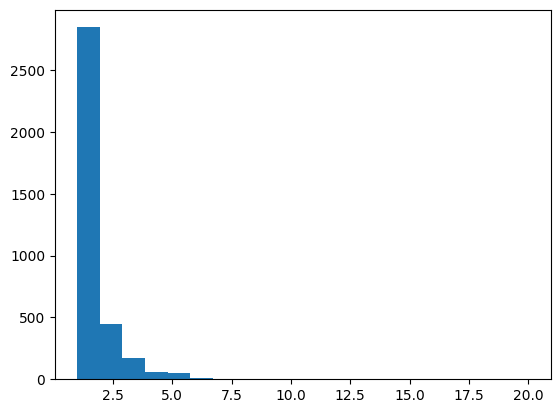

In [34]:
import matplotlib.pyplot as plt
nn_df['# substitutions'] = [len(x.split('_')) for x in nn_df['amino_acid_substitutions'].values]
plt.hist(nn_df['# substitutions'].values, bins=20)

In [35]:
many_subs = nn_df[nn_df['# substitutions'] > 10]
many_subs

,barcode_plate,plate,nucleotide_mutation,amino_acid_substitutions,well,average_mutation_frequency,alignment_count,aa_sequence,Sample_Acq_Order_No,Sample_Vial_Number,...,function_well,function_barcode_plate,filename,levSeq_filename,fitness_value,smiles_string,campaign_name,Area plate standard norm,Area fold change,# substitutions
36,18,HA-K43X,G24A_A39T_C66T_T86A_T93C_G99A_G106A_G133T_C134...,M29K_E36K_A45C_M59Y_R61G_V63A_F86L_W93F_V97I_A...,D1,0.551282,14.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...,22.0,D3F-D1,...,D1,18,JR-20250215-HA-K43X_achiral_18.csv,20250215_SSM-H2NOH,8.088097e+05,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,0.877117,2.177490,18
756,25,HA-R188X,G24A_A39T_C66T_T86A_T93C_G99A_G106A_G133T_C134...,M29K_E36K_A45C_M59Y_G60P_R61G_V63A_F86L_W93F_V...,H1,0.823129,14.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEKDVMYLKKACD...,39.0,D6B-H1,...,H1,25,JR-20250215-HA-P188X_achiral_25.csv,20250215_SSM-H2NOH,5.502202e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-0.619322,0.118460,20
30,37,HA-StEP1,C19T_A39T_C66T_T86A_T93C_T95C_G99A_C135T_C181G...,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,C7,0.776442,13.0,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVTLGEEDVMYLKKAAD...,32.0,D3F-C7,...,C7,37,JR-20250227-step1_37.csv,20250227_StEP-H2NOH,7.683532e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-5.512855,0.065423,17
84,37,HA-StEP1,C19T_A39T_C66T_T86A_T93C_T95C_G99A_C135T_C181G...,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,H1,0.783838,30.0,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVTLGEEDVMYLKKAAD...,86.0,D3F-H1,...,H1,37,JR-20250227-step1_37.csv,20250227_StEP-H2NOH,4.894387e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-5.652944,0.041674,18
96,38,HA-StEP2,C19T_A39T_C66T_T86A_T93C_T95C_G99A_C135T_C181G...,P7S_M29K_M32T_R61G_V63A_F73G_E80A_F86L_W93I_V9...,A1,0.820707,12.0,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVTLGEEDVMYLKKAAD...,2.0,D3B-A1,...,A1,38,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,5.802637e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-2.738083,0.042344,18
120,38,HA-StEP2,C19T_G38A_A39T_C66T_T86A_T93C_G99A_C135T_C181G...,P7S_R13H_M29K_R61G_V63L_E80A_F86L_W93C_G94V_A1...,C1,0.843094,181.0,MTPSDISGYDYGHVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,26.0,D3B-C1,...,C1,38,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,5.384710e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-2.746803,0.039294,18
122,38,HA-StEP2,C19T_G38A_A39T_C66T_T86A_T93C_G99A_C135T_C181G...,P7S_R13H_M29K_R61G_V63L_E80A_F86L_W93C_G94V_A1...,C3,0.613596,76.0,MTPSDISGYDYGHVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...,28.0,D3B-C3,...,C3,38,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,2.137870e+06,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,1.601389,1.560092,18
133,38,HA-StEP2,A39T_C66T_T86A_T93C_G99A_A107G_G112A_A114G_A12...,M29K_E36G_V38M_K43M_M59V_R61G_F86C_V89I_W93I_V...,D2,0.807983,103.0,MTPSDIPGYDYGRVEKSPITDLEFDLLKKTVMLGEGDMMYLKMAAD...,39.0,D3B-D2,...,D2,38,JR-20250227-step2_38.csv,20250227_StEP-H2NOH,5.919527e+04,O=C(OC)C[C@H](N)C1=CC=CC=C1,H2NOH_G5,-2.735644,0.043197,13


In [36]:
all_df.to_csv(f'{output_dir}/LevSeq_CombinedDF_pdt.csv', index=False)
nn_df.to_csv(f'{output_dir}/LevSeq_CombinedDF_pdt_filtered.csv', index=False)

In [40]:
nn_df = nn_df.sort_values(by='Area fold change', ascending=False)
len(set(nn_df['aa_sequence'].values))

1549

In [42]:
dedup = nn_df.drop_duplicates(subset=['aa_sequence'])
dedup.to_csv(f'{output_dir}/LevSeq_unique_variants.csv', index=False)